<center> <h1> <b>Song Birds<b></h1> </center>
<center> <h1>Model Automatization and Code Update</h1> </center>

# Import Libraries, Functions, and Classes

In [1]:
from birdsongs.song import *

C:\Users\sebas\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
root_path = "C:\\Users\\sebas\\Documents\\GitHub\\" # root_path = '/home/siete/Downloads/audios/'
bird_name = "Zonotrichia capensis"
paths     = Paths(root_path, bird_name)

The folder has 91 songs


Looking for all wav files in path folder and audios path

# Song and Syllable

## Song Definition

In [3]:
no_file = 1 # int(input("Enter the number of song (1 to {0}): ".format(paths.no_files)))
bird    = Song(paths, no_file)   

In [4]:
# Sxx,tn,fn,ext = sound.spectrogram(syllable.s, syllable.fs, fcrop=(2000,20000))   
# Sxx_dB = util.power2dB(Sxx)+96

# Sxx_dB_std05 = sound.smooth(Sxx_dB, std=0.5)
# Sxx_dB_std10 = sound.smooth(Sxx_dB, std=1)
# Sxx_dB_std15 = sound.smooth(Sxx_dB, std=1.5)

# import matplotlib.pyplot as plt 
# #fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
# util.plot2d(Sxx_dB,  title='original')#, vmin=10, vmax=70)
# util.plot2d(Sxx_dB_std05,   title='smooth (std=0.05)')#, vmin=10, vmax=70)
# util.plot2d(Sxx_dB_std10,   title='smooth (std=1)')#, vmin=10, vmax=70)
# util.plot2d(Sxx_dB_std15,   title='smooth (std=15.5)')#, vmin=10, vmax=70)
# fig.set_size_inches(7,9)
# fig.tight_layout()

256 512 True


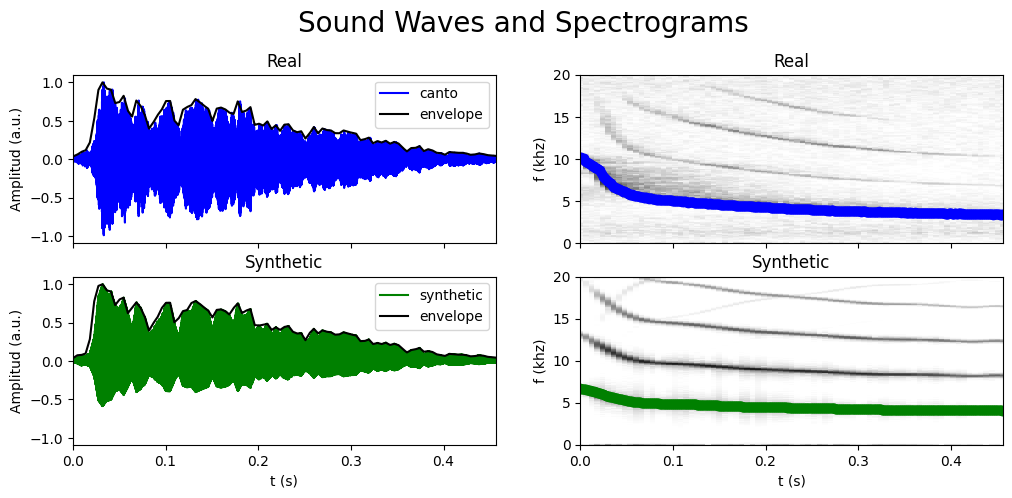

In [6]:
no_syllable = 4
syllable    = bird.Syllable(no_syllable)
syllable.Solve(bird.p)
syllable.PlotSynth()

128 256 True


Parameters([('a0', <Parameter 'a0', value=0.11 (fixed), bounds=[0:0.25]>), ('a1', <Parameter 'a1', value=0.05 (fixed), bounds=[-2:2]>), ('b0', <Parameter 'b0', value=-0.1 (fixed), bounds=[-1:0.5]>), ('b1', <Parameter 'b1', value=1 (fixed), bounds=[0.2:2]>), ('gamma', <Parameter 'gamma', value=40000.0 (fixed), bounds=[10000.0:100000.0]>), ('b2', <Parameter 'b2', value=0.0 (fixed), bounds=[-inf:inf]>), ('a2', <Parameter 'a2', value=0.0 (fixed), bounds=[-inf:inf]>)])

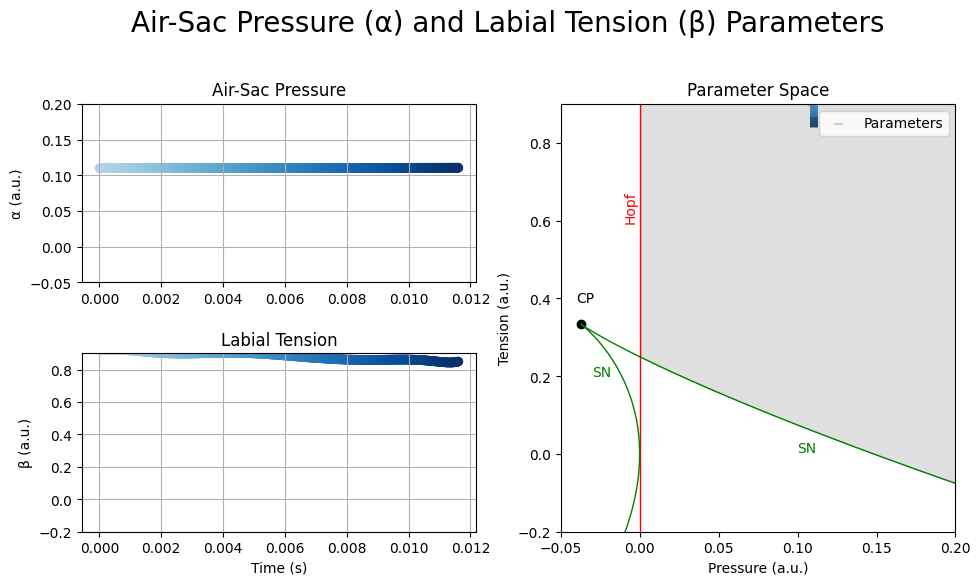

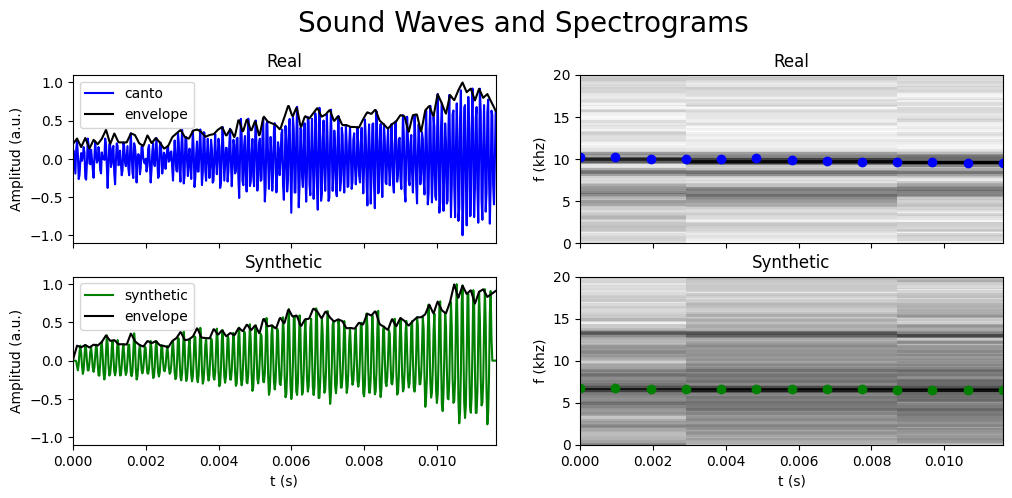

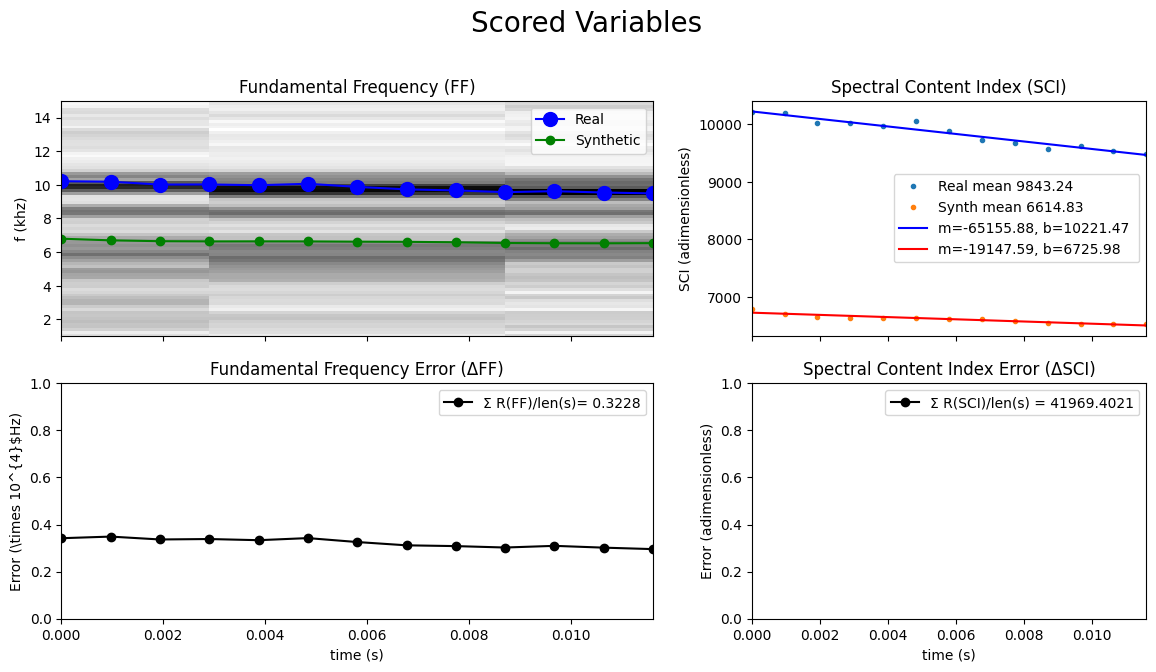

In [7]:
no_chunck = 1
chunck    = bird.Chunck(no_chunck)
chunck.Solve(bird.p)

display(chunck.p)
chunck.PlotAlphaBeta()
chunck.PlotSynth()
chunck.Plot(1)
#chunck.PlotVs()

In [ ]:
chunck_out = np.copy(chunck.out_amp)
#chunck_out[np.where(chunck_out<1e-3) ]=1e-3
f0_out = yin(chunck_out, fmin=1e3, fmax=15e3, sr=chunck.fs, frame_length=128,
            win_length=None, hop_length=None, trough_threshold=1, center=False, pad_mode='constant')
plt.plot(f0_out, 'o')

In [26]:
chunck.out_amp[0]

4.178822007168396e-08

## Song and Syllable Plot

In [ ]:
bird.Plot(1)

In [ ]:
no_syllable = 4
syllable    = bird.Syllable(no_syllable)
syllable.Solve(bird.p)
syllable.PlotSynth()

In [ ]:
plt.plot(chunck.FF, 'o-')

# Syllable i-th

## Definition

In [ ]:
# no_syllable = 1
# syllable    = bird.Syllable(no_syllable)
# syllable.Solve(bird.p)

## Plot

In [ ]:
# display(syllable.p)
# syllable.PlotAlphaBeta()
# syllable.PlotSynth()
# syllable.Plot(0)
# #syllable.PlotVs()

# Chunck i-th 

## Definition

In [ ]:
# no_chunck = 1
# chunck    = bird.Chunck(no_chunck)
# chunck.Solve(bird.p)

## Plot

In [ ]:
# display(chunck.p)
# chunck.PlotAlphaBeta()
# chunck.PlotSynth()
# chunck.Plot(1)
# #chunck.PlotVs()

In [ ]:
env  = sound.envelope(chunck.out_amp, Nt=chunck.Nt//50, mode="fast") 
t_env = np.arange(0,len(env),1)*len(chunck.out_amp)/syllable.fs/len(env)
t_env[-1] = chunck.time[-1] 
fun_s = interp1d(t_env, env)
env = fun_s(chunck.time)

plt.plot(chunck.out_amp)
plt.plot(chunck.s_amp_env)
plt.plot(env)

# Optimization Problem

## General Problem

General problem

\begin{equation}
\begin{aligned}
\underset{ \gamma \in \mathbb{R},\; a,b\in \mathbb{R}^2}{\text{min}} &\qquad  ||\hat{SCI}_{real} - \hat{SCI}_{synt} ( \gamma,a,b)||  + || (\hat{FF}_{real} - \hat{FF}_{synt}(\gamma,a,b)||\\
    \text { subject to }  & \qquad \gamma \in D_{\gamma}=[0.1, 100000] \\
                          & \qquad  b \in D_b=[-1,0.5]\times[0.2,2] \\
                          & \qquad  a \in D_a=[0,0.25]\times[-2,2] 
\end{aligned}
\end{equation}

with

$$
\hat{SCI} := \frac{1}{len(SCI)^2} SCI, \qquad
\hat{FF}  := \frac{1}{len(FF)^2} \frac{FF}{10 \; KHz}
$$

where $len()$ is the number of elements of the vector. 

## Auxiliar Problems

In order to solve it let's define three asociated problems

### Optimal $\gamma$

\begin{equation}
\begin{aligned}
\underset{ \gamma \in \mathbb{R}}{\text{min}} &\qquad  || \hat{SCI}_{real} - \hat{SCI}_{synt} ( \gamma)||  + || \hat{FF}_{real} - \hat{FF}_{synt}||\\
    \text { subject to }  & \qquad 10000 <  \gamma \leq 100000
\end{aligned}
\end{equation}

### Optimal $\beta$ coeficients

The second step is find the constants $b_i$

\begin{equation}
\begin{aligned}
\underset{b \in \mathbb{R}^2}{\text{min}} &\qquad || FF_{real} - FF_{synt} (b)||  \\
    \text { subject to }  & \qquad -1 <  b_0 \leq 0.5, \\
                          &\;\; \qquad 0.2 <  b_1 \leq 2
\end{aligned}
\end{equation}

with

\begin{gather}
\alpha(t) = a_0 + a_1 t, \qquad  \beta(t)=b_0  + b_1\frac{FF_{real}}{10^4} 
\end{gather}

with $t\in [0,T]$ where $T$ is the duration of the sillable (chunck).

### Optimal $\alpha$ coeficients

The coefficients $a_0$ and $a_1$ are calculated with the first harmonic 

\begin{equation}
\begin{aligned}
\underset{a \in \mathbb{R}^2}{\text{min}} &\qquad || \overline{H}_{real}^{st} - \overline{H}_{synt}^{st} (a)||  \\
    \text { subject to }  & \qquad \;\; 0 <  a_0 \leq 0.25, \\
                          & \qquad -2 <  a_1 \leq 2
\end{aligned}
\end{equation}

where $\overline{H}^{st}$ is used to represent the first harmonic amplitude.

## Minimization Solvers and Parameters

In [ ]:
brute         = {'method':'brute', 'Ns':21} #, 'workers':1} 
DualAnnealing = {'method':'dual_annealing','max_nfev':200, 'maxiter': 100}

You can check all the methods availables uncommenting the following line

In [ ]:
bird.AllGammas(brute)

Finding optimal $\gamma$, $b_0$, and $b_1$ by the brute method

## Minimization Solution

In [ ]:
#workers = Pool().map # crea pool to parallel programming for optimization

In [ ]:
brute["Ns"] = 21 #101
syllable.OptimalGamma(brute) 
syllable.OptimalBs(brute)

## Plot Solution

In [ ]:
display(syllable.p)
syllable.Solve(syllable.p)

In [ ]:
syllable.PlotAlphaBeta()
syllable.PlotSynth()
syllable.Plot(0)

## Write synthetic audio

In [ ]:
syllable.Audio()

# Whole Song

In [ ]:
#bird.WholeSong(brute, plot=True, syll_max=0)

## Optigam Gamma by Syllable

Calculate optimal gamma for each syllable

In [ ]:
#len(bird.syllables)

In [ ]:
#brute["Ns"] = 26
#for i in range(len(bird.syllables)):
#    bird.Syllable(i+1)
#    bird.SolveSyllable(bird.p)
#    bird.OptimalGamma(brute)
#    bird.syllable.p

# Proposal Functions

In [ ]:
# s, time = bird.silaba.out_amp, bird.silaba.time_out
# fs = bird.silaba.fs
# s_i, t = Windows(s, time, fs)
# i = -2
# f_msf, f_aff, amp = SpectralContentSynth(s_i[i], fs) # method=method
# f_aff#s_i.shape

# maximos = peakutils.indexes(np.abs(np.fft.rfft(s_i[i])), thres=0.15, min_dist=5)

# plt.plot(np.fft.rfftfreq(s_i[i].shape[0], 1/fs),  np.abs(np.fft.rfft(s_i[i])))
# #plt.plot(s_i[i])
# #plt.plot(s)

In [ ]:
#y    = np.abs(np.fft.rfft(bird.silaba.out_amp)) #[5:-5]
#freq = np.fft.rfftfreq(bird.silaba.out_amp.size, d=1/bird.fs)#[5:-5]

#freq, y = freq[5:-5], y # remove inital and final peaks
#peaks, _ = find_peaks(y, distance=10, height=np.max(y)/10)
#peaks = peakutils.indexes(y, thres=0.5, min_dist=30)

#plt.plot(freq,y); #plt.xlim((1, 2e4))
#plt.plot(freq[peaks[0]], y[peaks[0]], "x")

## Video
- Create a function to make video

```` 
import os
os.system("ffmpeg -f image2 -r 1/5 -i ./images/swissGenevaLake%01d.jpg -vcodec mpeg4 -y ./videos/swissGenevaLake.mp4")
````

- Add audio to the video

````
ffmpeg -i yourvideo.avi -i sound.mp3 -c copy -map 0:v:0 -map 1:a:0 output.avi
````

## Improve Pitch Extractor, extract harmonics

## Improve Normalizer and Envelope

## Make itartion for all sillables

# References

{cite}`perez2011python`

```{bibliography} references.bib
```
<div class="csl-entry">[1] Amador, A., Perl, Y. S., Mindlin, G. B., &#38; Margoliash, D. (2013). Elemental gesture dynamics are encoded by song premotor cortical neurons. <i>Nature 2013 495:7439</i>, <i>495</i>(7439), 59–64. <a href="https://doi.org/10.1038/nature11967">https://doi.org/10.1038/nature11967</a> </div>

<br>

<div class="csl-entry">[2] Newville, M., Stensitzki, T., Allen, D. B., &#38; Ingargiola, A. (2014). <i>LMFIT: Non-Linear Least-Square Minimization and Curve-Fitting for Python</i>. <a href="https://doi.org/10.5281/ZENODO.11813">https://doi.org/10.5281/ZENODO.11813</a> </div>
